# 1D Harmonic Oscillator

Here we will solve the Harmonic Oscillator (HO) in 1D for a single particle. The Hamiltonian reads, in HO units:

$$\hat{H}=-\frac{1}{2}\frac{d²}{dx²}+\frac{1}{2}mw²x²$$

In [1]:
# Imports
from IPython import display
import torch
from torch import nn, Tensor
from torch.autograd import grad
import numpy as np
import matplotlib.pylab as plt
from tqdm import tqdm
from torchviz import make_dot

# Hardware device (CPU or GPU)
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

## General parameters

We now define the various parameters and hyperparameters.

In [2]:
# Network hyperparameters
Nin = 1   # Inputs to the neural network
Nout = 1  # Outputs of the neural network
Nhid = 4  # Nodes in the hidden layer

# Network parameters.
seed = 1
W1 = torch.rand(Nhid, Nin, requires_grad=True) * (-1.) # First set of coefficients. Shape = (nodes, Nin)
B = torch.rand(Nhid, requires_grad=True) * 2. - 1.    # Set of bias parameters
W2 = torch.rand(Nout, Nhid, requires_grad=True)        # Second set of coefficients. Shape = (Nout, nodes)
torch.manual_seed(seed)

# Training hyperparameters
epochs = 3000
lr = 2e-2  # Learning rate

# Mesh parameters
n_samples = 100                    # Mesh division
train_a = -8                      # Mesh lower limit
train_b = 8                        # Mesh upper limit
h = (train_b - train_a)/(n_samples-1)  # Mesh parameter "h"
Q_train = torch.linspace(train_a, train_b, n_samples, 
                         requires_grad=True, 
                         device=device)  

target = (1/np.pi)**(1/4) * torch.exp(-Q_train.pow(2)/2).to(device)

## The neural network

We now create the neural network. In PyTorch every neural network must be created as a child of the ```nn.Module``` class. Inside the ```__init__``` method we define the layers. In our case we have a single hidden layer, and therefore a single activation function and two linear transformations (one at each "side" of the hidden layer). Then, inside the block ```with torch.no_grad():``` we define the initial parameters of the network.

Finally, inside the ```forward``` method we set the connections between the different elements of the network, this is, we set the network architecture.

In [3]:
class HarmonicNN(nn.Module):
    def __init__(self):
        super(HarmonicNN, self).__init__()
        
        # We set the operators 
        self.lc1 = nn.Linear(in_features=Nin, 
                             out_features=Nhid, 
                             bias=True)   # shape = (Nhid, Nin)
        self.actfun = nn.Sigmoid()        # activation function
        self.lc2 = nn.Linear(in_features=Nhid, 
                             out_features=Nout, 
                             bias=False)  # shape = (Nout, Nhid)
        
        # We set the parameters 
        with torch.no_grad():
            self.lc1.weight = nn.Parameter(W1)
            self.lc1.bias = nn.Parameter(B)
            self.lc2.weight = nn.Parameter(W2)
   
    # We set the architecture
    def forward(self, x): 
        o = self.lc2(self.actfun(self.lc1(x)))
        return o

The network we have just created has the following graph representation:

<img src="simple_ann.PNG"
     alt="Markdown Monster icon"
     style="float: center;" 
     width="500"
     height="400"/>
     
We can check that our code is actually producing this neural network with the following syntax: 

In [17]:
net = HarmonicNN().to(device)
print("NN architecture:\n", net)

NN architecture:
 HarmonicNN(
  (lc1): Linear(in_features=1, out_features=4, bias=True)
  (actfun): Sigmoid()
  (lc2): Linear(in_features=4, out_features=1, bias=False)
)


## The loss function

Now we must define the loss function, which in our case is the energy expectation computed with the HO Hamiltonian and our NQS. This is,
$$\newcommand{\bra}[1]{{ \left\langle #1 \right|} }
\newcommand{\ket}[1]{{ \left|  #1 \right\rangle } }
\mathcal{L}=\frac{\bra{\psi_\theta}\hat{H}\ket{\psi_\theta}}{\bra{\psi_\theta}\psi_\theta\rangle}. $$

This expression can be evaluated as two integrals in position space:

$$\bra{\psi_\theta}\hat{H}\ket{\psi_\theta}=\int_{-\infty}^\infty \psi\hat{H}\psi dx$$

$$ \bra{\psi_\theta}\psi_\theta\rangle=\int_{-\infty}^\infty \psi² dx$$

The first integral can be rewritten so that the second derivative does not appear. This will be useful when computing the loss function. The "trick" is to integrate the kinetic term by parts and impose that 

$$ \lim_{x\to -\infty}\psi(x) = \lim_{x\to +\infty}\psi(x) = 0. $$

After this step we can discretize the integrals according to our lattice:

$$ \bra{\psi_\theta}\hat{H}\ket{\psi_\theta}=\frac{1}{2}\int[(\frac{d\psi_\theta(x)}{dx})²+x²\psi_\theta²(x)]dx \approx \frac{1}{2}\sum_{i=1}^{N_x} w_i [(\frac{d\psi_\theta(x_i)}{dx})²+x²\psi_\theta²(x_i)], $$

$$\bra{\psi_\theta}\psi_\theta\rangle\approx \sum_{i=1}^{N_x} w_i \psi_\theta^2(x_i)\equiv N.$$

We now define the cost function:

In [16]:
def cost():
    X = Q_train.clone().unsqueeze(1)

# VECTORIZED VERSION OF FIRST AND SECOND DERIVATIVES    
    phi_t = net(X)    

    first_der, = grad(outputs=phi_t, 
                      inputs=X,
                      grad_outputs=torch.ones_like(phi_t), 
                      create_graph=True)            
    d_phi_t = first_der.clone()
    phi = phi_t.clone()
    
    N = h * torch.sum(phi_t.pow(2))                        
    U = h * (1/2) * torch.sum(X.pow(2) * phi_t.pow(2)) / N  
    K = h * (1/2) * torch.sum(d_phi_t.pow(2)) / N              

    E = U + K
    phi_t /= torch.sqrt(N)    
    
    return E, U, K, phi, phi_t

## Plotting

We set the function that does the plots periodically. 

In [14]:
def pic(i, x, y, y1, loss, U, K):
    
    # Overlap
    ax1.set_title("Epoch {}".format(i+1))
    wf=y.detach().numpy()
    if( np.max(wf) < 0 ) : wf = -wf
    ax1.plot(x.detach().numpy(), wf, label='$\psi_\mathrm{NN}$')
    ax1.plot(x.detach().numpy(), target.detach().numpy(), linestyle="--", 
             label='$\psi_\mathrm{target}$')
    ax1.legend()
    
    # Wave function
    ax2.set_title("Epoch {}".format(i+1))
    ax2.plot(x.detach().numpy(), y1.detach().numpy(), 
             label='$\psi_\mathrm{NQS/envelope}$')
    ax2.legend()

    # Loss
    ax3.set_title("Loss Function")
    ax3.plot(np.linspace(1, i+1, i+1), loss.detach().numpy(), label='$E$')
    ax3.plot(np.linspace(1, i+1, i+1), U.detach().numpy(), label='$U$')
    ax3.plot(np.linspace(1, i+1, i+1), K.detach().numpy(), label='$K$')
    ax3.plot(np.linspace(1, i+1, i+1), torch.ones(i+1).numpy()-0.5, 
             linestyle='--', label='$E_0$')
    ax3.plot(np.linspace(1, i+1, i+1), torch.ones(i+1).numpy()-0.75, 
             linestyle='--', label='$U_0, K_0$')
    ax3.legend() 
    
    fig.canvas.draw()

## Training the network

We are now ready to train the neural network. The first part of the code is related to the plots that will be periodically created during the training, and the actual training happens inside the ```for``` loop. The key lines of code are the following.

``` optimizer.zero_grad() ``` sets all gradients to zero so as not to accumulate the ones from the previous iteration or epoch.

``` loss.backward() ``` computes the gradient of the loss w.r.t. the parameters passed to the optimizer using the backpropagation algorithm. These gradient components are stored inside the ```.grad```attribute of the tensors with the ```requires_grad``` flag set to ```True```.

``` optimizer.step() ``` uses the gradient information just computed to update the parameters $\theta$. 



Loading...:   0%|                                                                            | 0/3000 [00:00<?, ?it/s]


RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [100, 1]], which is output 0 of DivBackward0, is at version 1; expected version 0 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).

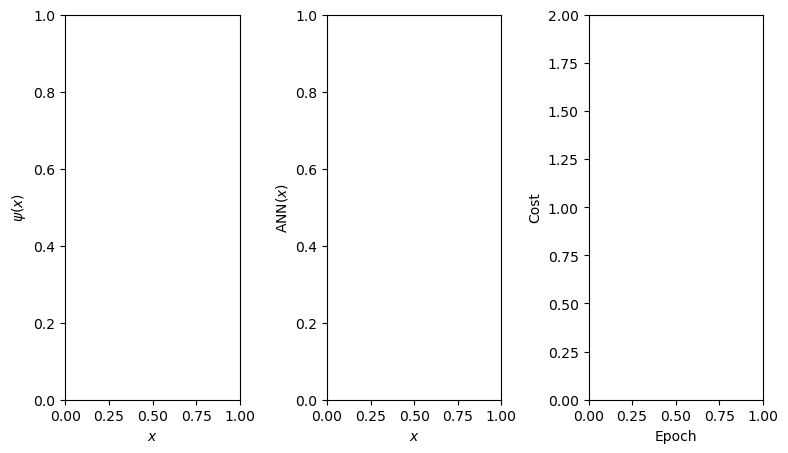

In [18]:
# Plotting
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(9, 5))
ax1, ax2, ax3 = ax[0], ax[1], ax[2]
plt.subplots_adjust(wspace=0.5)

# Overlap
ax1.set_xlabel("$x$")
ax1.set_ylabel("$\psi(x)$")

# Wave function
ax2.set_xlabel("$x$")
ax2.set_ylabel("$\{ANN}(x)$")
    
# Loss
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Cost")
ax3.set_ylim(0, 2)

tot_loss = []
tot_U = []
tot_K = []

# Training
for i in tqdm(range (epochs), desc="Loading..."):
    loss, U, K, phi, ph = cost()    # Energy and \phi calculation
    
    optimizer.zero_grad() # initialize gradients to zero at each epoch
    loss.backward()       # computation of the gradients
    optimizer.step()      # update of the parameters
    
    loss, U, K, ph,phi = cost() 
    tot_loss.append(loss.detach())
    tot_U.append(U.detach())
    tot_K.append(K.detach())
    
    if i == epochs - 1 or (i % 100 == 0):
        tot_loss1 = torch.stack(tot_loss)
        tot_U1 = torch.stack(tot_U)
        tot_K1 = torch.stack(tot_K)
        pic(i, Q_train, phi, ph, tot_loss1, tot_U1, tot_K1)